In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## **Obtener los datos**

In [ ]:
url = 'https://ycharts.com/companies/TSLA/revenues'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36' }
response = requests.get(url, headers=headers) # Enviar una solicitud para obtener el contenido de la página

In [ ]:
if response.status_code == 200: # Comprobar si la solicitud se ha aceptado
    soup = BeautifulSoup(response.content, 'html.parser')

#Busco todas las tablas en la página
tables = soup.find_all('table')

## **CREAR EL DATAFRAME**

In [ ]:
all_data = []  #Donde se almaceno la data de cada fila
for table in tables:
        rows = table.find_all('tr')[1:]  # Omitir el encabezado
        
        for row in rows:
            cells = row.find_all('td')
            date = cells[0].get_text(strip=True)
            value = cells[1].get_text(strip=True)
            all_data.append([date, value])
    
df = pd.DataFrame(all_data, columns=['Date', 'Value'])


tabla_ingresos = df[:50] #Elimino las filas que no forman parte de la tabla "Historical Revenue (Quarterly) Data"

tabla_ingresos['Value'] = tabla_ingresos['Value'].replace('[\$,B,M]', '', regex=True).astype(float)
tabla_ingresos.loc[tabla_ingresos.index < 35, 'Value'] = tabla_ingresos.loc[tabla_ingresos.index < 35, 'Value']*1000 #Convierto a millones los que estan en billones
tabla_ingresos

In [ ]:
tabla_ingresos['Date'] = pd.to_datetime(tabla_ingresos['Date']) # Para convertir la columna Date a un objeto datetime.
tabla_ingresos['Date'] = tabla_ingresos['Date'].dt.strftime('%d-%m-%Y')
tabla_ingresos


## **Conectar en SQL**

In [ ]:
import sqlite3
connection = sqlite3.connect("Tesla.db")
connection

In [ ]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE IF NOT EXISTS Ingresos (Date, Value)""")

In [ ]:
tesla_tuples = list(tabla_ingresos.to_records(index = False))
connection.commit()

In [ ]:
cursor.executemany("INSERT INTO Ingresos VALUES (?,?)", tesla_tuples)
connection.commit()

In [ ]:
for row in cursor.execute("SELECT * FROM Ingresos"):
    print(row)

## **GRÁFICOS**

C:\Users\macar\AppData\Local\Temp\ipykernel_19448\1168743637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_ingresos["Date"] = pd.to_datetime(tabla_ingresos["Date"])
C:\Users\macar\AppData\Local\Temp\ipykernel_19448\1168743637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_ingresos["Value"] = tabla_ingresos["Value"].astype('int')


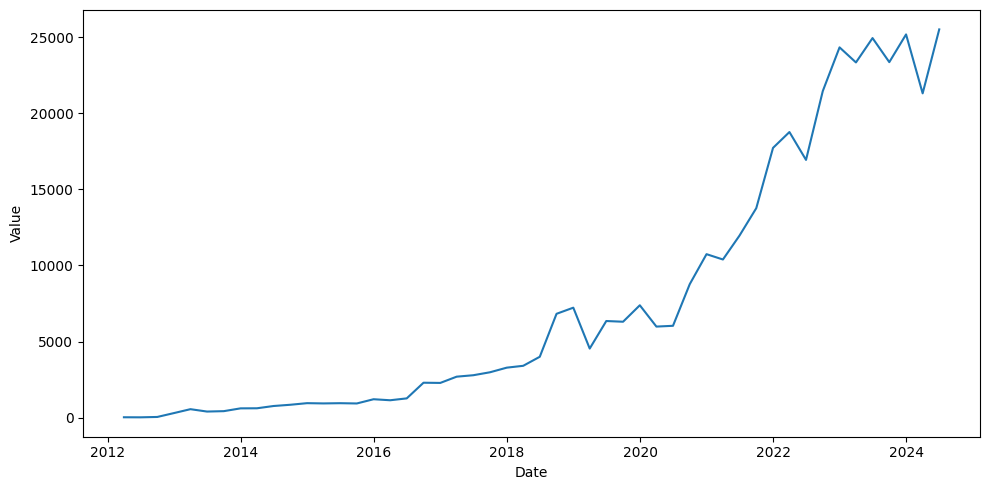

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tabla_ingresos["Date"] = pd.to_datetime(tabla_ingresos["Date"])
tabla_ingresos["Value"] = tabla_ingresos["Value"].astype('int')
sns.lineplot(data = tabla_ingresos, x = "Date", y = "Value")

plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Distribución de los ingresos de Tesla')

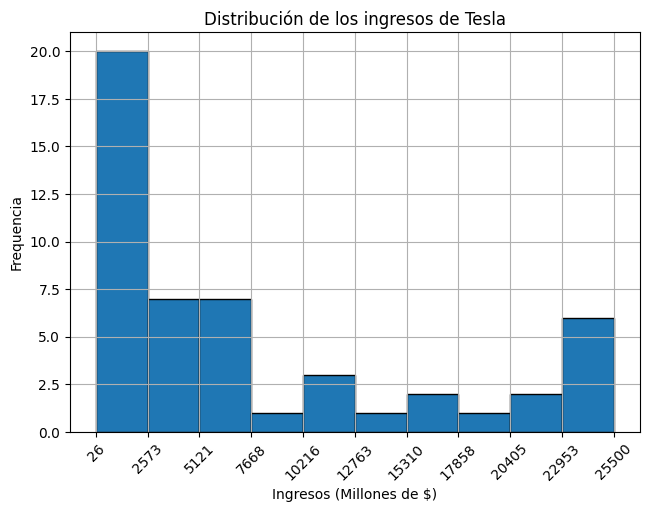

In [81]:
n, bins, patches = plt.hist(tabla_ingresos['Value'], bins= 10, edgecolor = 'black')
plt.xticks(bins, rotation=45)  # Rotar etiquetas 45 grados
# Ajustar los márgenes para que las etiquetas no se corten
plt.tight_layout()
plt.grid(True)
plt.xlabel('Ingresos (Millones de $)')
plt.ylabel('Frequencia')
plt.title('Distribución de los ingresos de Tesla')

{'whiskers': [<matplotlib.lines.Line2D at 0x204891fb520>,
 'caps': [<matplotlib.lines.Line2D at 0x204891fba60>,
 'boxes': [<matplotlib.patches.PathPatch at 0x204891fb130>],
 'medians': [<matplotlib.lines.Line2D at 0x204891fbfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20489230280>],
 'means': []}

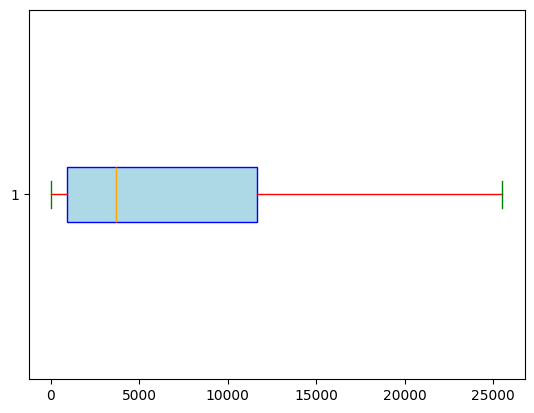

In [80]:
plt.boxplot(tabla_ingresos['Value'], vert=False, patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', color='blue'),
                   whiskerprops=dict(color='red'),
                   capprops=dict(color='green'),
                   medianprops=dict(color='orange'))

Observando los gráficos podemos observar varias cosas:
    - Tesla ha augmentado de forma casi exponencial sus ingresos
    - La distribución de los ingresos aún así, está muy intensificda entre los 25 y 5000 millones de dólares estadounidenses. El otro 50 % se reparte de los 5000 hasta los 25000 millones, lo cuál podemos decir que la causa viene dado a los últimos aumentos tan significativos en ingresos durante estos ultimos años.